In [2]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm.auto import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080'

# example below

In [4]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"data"

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 64, we use this to speed up training
SIZE_H = SIZE_W = 96

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 128

In [5]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create an ImageFolder instance to be used during training, validation and testing phases.

In [6]:
# load dataset using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [7]:
# load test data also, to be used for final evaluation
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Save sample num for further use

In [8]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [9]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

In [10]:
       val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [11]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             num_workers=NUM_WORKERS)

Let's create a helper function to vizualize images from our data loaders (and also make sure data was properly loaded).

In [12]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

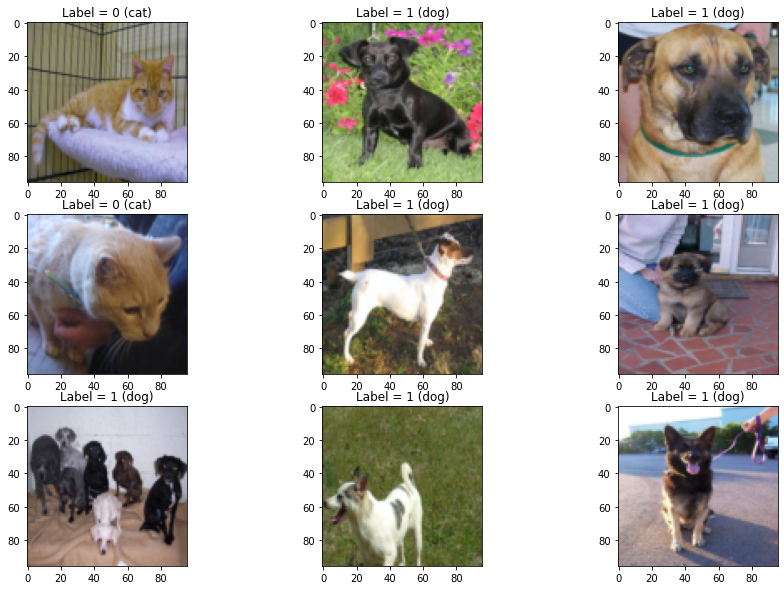

In [17]:
plot_from_batch_generator(train_batch_gen)

In [18]:
#from IPython.display import clear_output

class Runner():
    """Runner for experiments with supervised model."""
    def __init__(self, model, opt, device, checkpoint_name=None):
        self.model = model
        self.opt = opt
        self.device = device
        self.checkpoint_name = checkpoint_name
        
        self.epoch = 0
        self.output = None
        self.metrics = None
        self._global_step = 0
        self._set_events()
        self._top_val_accuracy = -1
        self.log_dict = {
            "train": [],
            "val": [],
            "test": []
        }
    
    def _set_events(self):
        """
        Additional method to initialize variables, which may store logging and evaluation info.
        The implementation below is extremely simple and only provided to help monitor performance.
        """
        self._phase_name = ''
        self.events = {
            "train": defaultdict(list),
            "val": defaultdict(list),
            "test": defaultdict(list)
        }
    
    def _reset_events(self, event_name):
        self.events[event_name] = defaultdict(list)
    
    def forward(self, img_batch, **kwargs):
        """
        Forward method for your Runner.
        Should not be called directly outside your Runner.
        In simple case, this method should only implement your model forward pass.
        It should also return the model predictions and/or other meta info.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
            **kwargs: additional parameters to pass to the model.
        """
        logits = self.model(img_batch)
        output = {
            "logits": logits,
        }
        return output
    
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        raise NotImplementedError("To be implemented")
    
    def output_log(self):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Implement this method for logging purposes.
        """
        raise NotImplementedError("To be implemented")
    
    def _run_batch(self, batch):
        """
        Runs batch of data through the model, performing forward pass.
        This implementation performs data passing to necessary device and is adapted to the default pyTorch DataLoader.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        # split batch tuple into data batch and label batch
        X_batch, y_batch = batch

        # update the global step in iterations over source data
        self._global_step += len(y_batch)
        
        # move data to target device
        X_batch = X_batch.to(self.device)
        
        # run the batch through the model
        self.output = self.forward(X_batch)
    
    def _run_epoch(self, loader, train_phase=True, output_log=False, **kwargs):
        """
        Method that runs one epoch of the training process.
        
        Args:
            loader (DataLoader): data loader to iterate
            train_phase (bool): boolean value to determine if this is the training phase.
                Changes behavior for dropout, batch normalization, etc.
        """
        # Train phase
        # enable or disable dropout / batch_norm training behavior
        self.model.train(train_phase)
        
        _phase_description = 'Training' if train_phase else 'Evaluation'
        for batch in tqdm(loader, desc=_phase_description, leave=False):
            
            # forward pass through the model using preset device
            self._run_batch(batch)
            
            # train on batch: compute loss and gradients
            with torch.set_grad_enabled(train_phase):
                loss = self.run_criterion(batch)
            
            # compute backward pass if training phase
            # reminder: don't forget the optimizer step and zeroing the grads
            if train_phase:
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()
        
        self.log_dict[self._phase_name].append(np.mean(self.events[self._phase_name]['loss']))
        
        if output_log:
            self.output_log(**kwargs)
    
    def train(self, train_loader, val_loader, n_epochs, model=None, opt=None, **kwargs):
        """
        Training process method, that runs for n_epochs over train_loader and performs validation using val_loader.
        
        Args:
            train_loader (DataLoader): training set data loader to iterate over
            val_loader (DataLoader): validation set data loader to iterate over
            n_epochs (int): epoch number to train for
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self.opt = (opt or self.opt)
        self.model = (model or self.model)
        
        for _epoch in range(n_epochs):
            start_time = time.time()
            self.epoch += 1
            print("Epoch {:3d}/{:3d} started".format(self.epoch, n_epochs))
            
            # training part
            self._set_events()
            self._phase_name = 'train'
            self._run_epoch(train_loader, train_phase=True)
            
            print("Epoch {:3d}/{:3d} took {:.2f}s".format(self.epoch, n_epochs, time.time() - start_time))
            
            # validation part
            self._phase_name = 'val'
            self.validate(val_loader, **kwargs)
            self.save_checkpoint()
    
    @torch.no_grad() # we do not need to save gradients during validation
    def validate(self, loader, model=None, phase_name='val', **kwargs):
        """
        Validation process method, that estimates the performance of self.model on validation data in loader.
        
        Args:
            loader (DataLoader): validation set data loader to iterate over
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self._phase_name = phase_name
        self._reset_events(phase_name)
        self._run_epoch(loader, train_phase=False, output_log=True, **kwargs)
        return self.metrics

In [19]:
from sklearn.metrics import f1_score, accuracy_score

class CNNRunner(Runner):
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        X_batch, label_batch = batch
        label_batch = label_batch.to(device)
        
        logit_batch = self.output['logits']
        
        # compute loss funciton
        loss = nn.CrossEntropyLoss()(logit_batch, label_batch)
        
        scores = F.softmax(logit_batch, 1).detach().cpu().numpy()[:, 1].tolist()
        labels = label_batch.detach().cpu().numpy().ravel().tolist()
        
        # log some info
        self.events[self._phase_name]['loss'].append(loss.detach().cpu().numpy())
        self.events[self._phase_name]['scores'].extend(scores)
        self.events[self._phase_name]['labels'].extend(labels)
        
        return loss
    
    def save_checkpoint(self):
        val_accuracy = self.metrics['accuracy']
        # save checkpoint of the best model to disk
        if val_accuracy > self._top_val_accuracy and self.checkpoint_name is not None:
            self._top_val_accuracy = val_accuracy
            torch.save(self.model, open(self.checkpoint_name, 'wb'))
    
    def output_log(self, **kwargs):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Let's have a fancy code for classification metrics calculation.
        """
        scores = np.array(self.events[self._phase_name]['scores'])
        labels = np.array(self.events[self._phase_name]['labels'])
        
        assert len(labels) > 0, print('Label list is empty')
        assert len(scores) > 0, print('Score list is empty')
        assert len(labels) == len(scores), print('Label and score lists are of different size')
        
        visualize = kwargs.get('visualize', False)
        if visualize:
            clear_output()
        
        self.metrics = {
            "loss": np.mean(self.events[self._phase_name]['loss']),
            "accuracy": accuracy_score(labels, np.int32(scores > 0.5)),
            "f1": f1_score(labels, np.int32(scores > 0.5))
        }
        print('{}: '.format(self._phase_name), end='')
        print(' | '.join(['{}: {:.4f}'.format(k,v) for k, v in self.metrics.items()]))
        
        self.save_checkpoint() 
        
        if visualize:
            # tensorboard for the poor
            fig = plt.figure(figsize=(15,5))
            ax1 = fig.add_subplot(1,2,1)
            ax2 = fig.add_subplot(1,2,2)
            
            ax1.plot(self.log_dict['train'], color='b', label='train')
            ax1.plot(self.log_dict['val'], color='c', label='val')
            ax1.legend()
            ax1.set_title('Train/val loss.')
            
            class_0_scores = np.array(scores)[np.array(labels) == 0]
            class_1_scores = np.array(scores)[np.array(labels) == 1]
            ax2.hist(class_0_scores, bins=50, range=[0,1.01], color='r', alpha=0.7, label='cats')
            ax2.hist(class_1_scores, bins=50, range=[0,1.01], color='g', alpha=0.7, label='dogs')
            ax2.legend()
            ax2.set_title('Validation set score distribution.')
            
            plt.show()

In [20]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
for p in model_resnet18.parameters():
    p.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_feat = model_resnet18.fc.in_features

model_resnet18.fc = nn.Linear(num_feat, NUM_CLASSES) #YOUR CODE HERE: # add your own prediction part: FC layer for 2 classes

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [21]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 48, 48]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 48, 48]          (128)
├─ReLU: 1-3                              [-1, 64, 48, 48]          --
├─MaxPool2d: 1-4                         [-1, 64, 24, 24]          --
├─Sequential: 1-5                        [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-1                   [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 24, 24]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 24, 24]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 24, 24]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 24, 24]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-2                   [-1, 64, 24, 24]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 48, 48]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 48, 48]          (128)
├─ReLU: 1-3                              [-1, 64, 48, 48]          --
├─MaxPool2d: 1-4                         [-1, 64, 24, 24]          --
├─Sequential: 1-5                        [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-1                   [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 24, 24]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 24, 24]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 24, 24]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 24, 24]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-2                   [-1, 64, 24, 24]  

In [19]:
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)
ckpt_name_resnet18='model_resnet_18_finetune.ckpt'

runner_finetune = CNNRunner(model_resnet18, opt_resnet, device, ckpt_name_resnet18)
runner_finetune.train(train_batch_gen, val_batch_gen, n_epochs=10, visualize=True)

val: loss: 0.3521 | accuracy: 0.8400 | f1: 0.8367


NameError: name 'model' is not defined